In [6]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn.modules.loss import *
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
%matplotlib notebook

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [ ]:
trainset.data[0]

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
model_base = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(7 * 7 * 64, 1000),
    nn.Linear(1000, 10),
    # nn.LogSoftmax()
)

sess_base = Session(model_base, nn.CrossEntropyLoss(), optim.Adam, 1e-3)

In [ ]:
lr_find(sess_base, trainloader, start_lr=1e-7)

In [ ]:
sess_base.set_lr(1e-4)

In [ ]:
validator = Validator(valloader, OneHotAccuracy())
lr_scheduler = CosAnneal(len(trainloader), T_mult=2)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 7)

In [6]:
class TripletRegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha, margin):     
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        
    def forward(self, x, y):
        loss = F.cross_entropy(x[-1], y)
        triplet = 0
        
        for layer in x[:-1]:
            triplet += batch_hard_triplet_loss(layer.view(layer.size(0), -1), y, self.margin)
            
        #triplet *= min(self.alpha/math.sqrt(loss.item()), 1)
        triplet *= self.alpha
            
        return loss + triplet

In [7]:
class CustomOneHotAccuracy(OneHotAccuracy):
    def __init__(self):
        super().__init__()
        self.reset()

    def update(self, output, label):
        super().update(output[-1], label)

In [14]:
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in modules_dict.items():
            self.add_module(key, module)
        self._to_select = to_select
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():
            x = module(x)
            if name in self._to_select:
                list.append(x)
        return list
    
model = SelectiveSequential(
    ['max2', 'fc1', 'out'],
    {'conv1': nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
    'act1': nn.ReLU(),
    'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    'conv2': nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
    'act2': nn.ReLU(),
    'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    'flatten': Flatten(),
    'fc1': nn.Linear(7 * 7 * 64, 1000),
    'out': nn.Linear(1000, 10)}
)

In [15]:
criterion = TripletRegularizedCrossEntropyLoss(.25, 1)

In [16]:
test = util.to_gpu(model).forward(util.to_gpu(torch.randn(6, 1, 28, 28)))
labels = util.to_gpu(torch.Tensor([0, 0, 0, 1, 1, 1]).long())
criterion.forward(test, labels)

tensor(2.8023, device='cuda:0', grad_fn=<AddBackward0>)

In [17]:
sess = Session(model, criterion, optim.Adam, 1e-3)

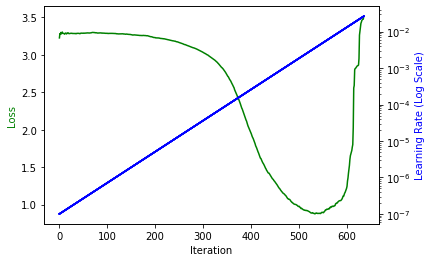

In [18]:
lr_find(sess, trainloader, start_lr=1e-7)

In [19]:
sess.set_lr(5e-4)

In [20]:
validator = Validator(valloader, CustomOneHotAccuracy())
lr_scheduler = CosAnneal(len(trainloader), T_mult=2)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 31)

Validating: 100%|██████████| 157/157 [00:02<00:00, 54.40it/s]

Training Loss: 0.48278191685676575  Validaton Loss: 0.3892931640148163 Validation Accuracy: 0.9878


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.69it/s]

Training Loss: 0.40799927711486816  Validaton Loss: 0.3332143723964691 Validation Accuracy: 0.991


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.54it/s]

Training Loss: 0.35060665011405945  Validaton Loss: 0.307943195104599 Validation Accuracy: 0.9919


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.10it/s]

Training Loss: 0.3686303496360779  Validaton Loss: 0.3110942244529724 Validation Accuracy: 0.9889


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.19it/s]

Training Loss: 0.3231957256793976  Validaton Loss: 0.2849443256855011 Validation Accuracy: 0.991


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.65it/s]

Training Loss: 0.29303839802742004  Validaton Loss: 0.27548032999038696 Validation Accuracy: 0.9916


Validating: 100%|██████████| 157/157 [00:02<00:00, 56.36it/s]

Training Loss: 0.2791387736797333  Validaton Loss: 0.2712422311306 Validation Accuracy: 0.9923000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.22it/s]

Training Loss: 0.3293519616127014  Validaton Loss: 0.2802492380142212 Validation Accuracy: 0.9926


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.56it/s]

Training Loss: 0.3207559585571289  Validaton Loss: 0.2907816469669342 Validation Accuracy: 0.9895


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.39it/s]

Training Loss: 0.28446102142333984  Validaton Loss: 0.2663111984729767 Validation Accuracy: 0.9919


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.83it/s]

Training Loss: 0.276206910610199  Validaton Loss: 0.2600806951522827 Validation Accuracy: 0.9923000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.73it/s]

Training Loss: 0.2573283314704895  Validaton Loss: 0.25148895382881165 Validation Accuracy: 0.9932000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.30it/s]

Training Loss: 0.2512831687927246  Validaton Loss: 0.24675582349300385 Validation Accuracy: 0.9925


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.29it/s]

Training Loss: 0.25159987807273865  Validaton Loss: 0.24534176290035248 Validation Accuracy: 0.9927


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.05it/s]

Training Loss: 0.24590173363685608  Validaton Loss: 0.24469970166683197 Validation Accuracy: 0.9931000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.91it/s]

Training Loss: 0.2944594919681549  Validaton Loss: 0.2702571153640747 Validation Accuracy: 0.9923000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.08it/s]

Training Loss: 0.29658880829811096  Validaton Loss: 0.26688262820243835 Validation Accuracy: 0.9915


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.35it/s]

Training Loss: 0.2732046842575073  Validaton Loss: 0.2605436444282532 Validation Accuracy: 0.9913000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.70it/s]

Training Loss: 0.26903554797172546  Validaton Loss: 0.25603199005126953 Validation Accuracy: 0.9921000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.06it/s]

Training Loss: 0.250450998544693  Validaton Loss: 0.2548415958881378 Validation Accuracy: 0.9906


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.53it/s]

Training Loss: 0.25124919414520264  Validaton Loss: 0.24845929443836212 Validation Accuracy: 0.991


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.21it/s]

Training Loss: 0.2287670224905014  Validaton Loss: 0.23944416642189026 Validation Accuracy: 0.9932000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.75it/s]

Training Loss: 0.24180001020431519  Validaton Loss: 0.2322581708431244 Validation Accuracy: 0.9927


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.35it/s]

Training Loss: 0.22656741738319397  Validaton Loss: 0.23534813523292542 Validation Accuracy: 0.9934000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.74it/s]

Training Loss: 0.22216500341892242  Validaton Loss: 0.23231224715709686 Validation Accuracy: 0.9926


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.20it/s]

Training Loss: 0.21489569544792175  Validaton Loss: 0.22838710248470306 Validation Accuracy: 0.9932000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.08it/s]

Training Loss: 0.2118447870016098  Validaton Loss: 0.22687682509422302 Validation Accuracy: 0.9932000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.45it/s]

Training Loss: 0.20311057567596436  Validaton Loss: 0.22396542131900787 Validation Accuracy: 0.9933000000000001


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.11it/s]

Training Loss: 0.20922239124774933  Validaton Loss: 0.22505655884742737 Validation Accuracy: 0.9929


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.27it/s]

Training Loss: 0.21558518707752228  Validaton Loss: 0.2240961641073227 Validation Accuracy: 0.993


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.79it/s]

Training Loss: 0.2043943852186203  Validaton Loss: 0.22415170073509216 Validation Accuracy: 0.993

